# General information

In Don't Overfit! II competition we have a binary classification task. 300 columns, 250 training samples and 79 times more samples in test data! We need to be able to build a model without overfitting.

In this kernel I'll write the following things:

* EDA on the features and trying to get some insights;
* Using permutation importance to select most impactful features;
* Comparing various models: bayer classification, linear models, tree based models;
* Trying various approaches to feature selection including taking top features from eli5 and shap;
* Hyperparameter optimization for models;
* Feature generation;
* Other things;

![](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb

from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
# import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape

(250, 302)


## Data exploration

In [ ]:
train.head()

In [ ]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

In [ ]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

In [ ]:
# we have no missing values
train.isnull().any().any()

In [ ]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [ ]:
train['target'].value_counts()

From this overview we can see the following things:
* target is binary and has some disbalance: 36% of samples belong to 0 class;
* values in columns are more or less similar;
* columns have std of 1 +/- 0.1 (min and max values are 0.889, 1.117 respectively);
* columns have mean of 0 +/- 0.15 (min and max values are -0.2, 0.1896 respectively);

Let's have a look at correlations now!

In [ ]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

We can see that correlations between features are lower that 0.3 and the most correlated feature with target has correlation of 0.37. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

## Basic modelling

In [3]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)
# X_train += np.random.normal(0, 0.1, X_train.shape)
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [4]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
                  
            
        if model_type == 'sklearn':
            model = model
#             print(X_train.shape)
#             print(y_train.shape)
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]

        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [ ]:
# A lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
# model = linear_model.Lasso(alpha=0.03, tol=0.01, selection='random', random_state=42)
# model = linear_model.LogisticRegressionCV(cv=5, class_weight='balanced', penalty='l1', Cs=20, solver='liblinear', multi_class='ovr')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
c = open('./scores_sklearn.csv','w+')
b = open('./prediction_lr_repeated_sklearn.csv','w+')
i = 0
for x in prediction_lr:
    b.write(str(x)+'\n')
.        i+=1
for y in scores:
    c.write(str(y)+'\n')
print(i)
b.close()

c.close()

In [5]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(X_train, y_train)
# m.predict_proba(test[labels])[:,1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.8, gamma=2, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.5,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [6]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(X_train, y_train)

# print(isf.score_samples(X_train))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=1, verbose=0)

In [7]:
arr = isf.predict(X_train)
arr = np.array(np.where(arr==-1))
arr=arr.reshape(-1)
print(arr.shape)
X_train = X_train.drop(arr)
y_train = y_train.drop(arr)

(25,)


In [8]:
from sklearn.ensemble import ExtraTreesClassifier

TOP_FEATURES = 15

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]
indices
print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))
# print(X_train.shape)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


Top features:
1. feature 33 (0.048426)
2. feature 65 (0.023535)
3. feature 117 (0.013435)
4. feature 116 (0.009164)
5. feature 4 (0.008982)
6. feature 217 (0.008768)
7. feature 91 (0.008572)
8. feature 39 (0.008474)
9. feature 119 (0.008161)
10. feature 80 (0.008042)
11. feature 189 (0.008041)
12. feature 259 (0.007760)
13. feature 252 (0.007628)
14. feature 90 (0.007457)
15. feature 243 (0.007179)


In [9]:
X_train = X_train[[str(x) for x in indices]]
print(X_train.shape)

(225, 15)


In [10]:
X_test = X_test[[str(x) for x in indices]]
print(X_test.shape)

(19750, 15)


In [11]:
# X_train += np.random.normal(0, 0.1, X_train.shape)
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:

def column_or_1d(y, warn=False):
    """ Ravel column or 1d numpy array, else raises an error

    Parameters
    ----------
    y : array-like

    warn : boolean, default False
       To control display of warnings.

    Returns
    -------
    y : array

    """
    shape = np.shape(y)
    if len(shape) == 1:
        return np.ravel(y)
    if len(shape) == 2 and shape[1] == 1:
        if warn:
            warnings.warn("A column-vector y was passed when a 1d array was"
                          " expected. Please change the shape of y to "
                          "(n_samples, ), for example using ravel().",
                          DataConversionWarning, stacklevel=2)
        return np.ravel(y)

    raise ValueError("bad input shape {0}".format(shape))

In [23]:
X_train=np.where(np.abs(X_train)< 0.000001, 0.1, X_train)
print(X_train)
print(y_train)
# np.any(np.isnan(X_train))
# np.all(np.isfinite(X_train))
# print(np.isnan(y_train).any())
# 
# y = column_or_1d(y_train, warn=True)
# print(np.isnan(y_train).any())
print(y_train.dtype.kind in 'fc')
# print(np.isfinite(y.sum()))
# print(np.isinf(y).any())
# print(np.isfinite(y).all())
# y = np.asanyarray(y)
# print(y)
# print(y_train.shape)
# print(np.isnan(y_train).any())
# print(y.dtype.kind in 'fc')
# print(np.isfinite(y.sum()))
# print(np.isinf(y).any())
# print(np.isfinite(y).all())

[[ 0.53122447 -0.8243413   0.66764043 ...  0.70410223 -1.75202764
  -0.90105456]
 [-2.59022291  1.24906648  0.93468203 ...  0.90164791 -0.03303986
   1.27261372]
 [ 1.07290513  0.95956002 -0.3870293  ...  0.6312213   0.72561371
  -0.60185662]
 ...
 [ 0.14531469 -1.08364745  1.63361763 ... -1.01723024 -0.54821371
  -0.16580159]
 [-0.48882353 -0.41090941 -0.40245408 ... -0.77077763 -0.83558248
   0.95170742]
 [-0.45867433  0.48156195  1.2325732  ...  0.0663941   0.39644584
   1.25939993]]
0      1.0
1      0.0
2      1.0
3      1.0
4      1.0
7      1.0
8      1.0
9      1.0
10     0.0
11     1.0
12     1.0
13     0.0
14     0.0
15     1.0
16     1.0
17     0.0
18     1.0
19     1.0
20     1.0
21     1.0
22     0.0
24     1.0
25     1.0
26     1.0
27     1.0
29     1.0
30     1.0
31     1.0
32     1.0
33     1.0
      ... 
216    1.0
217    1.0
218    0.0
219    1.0
220    1.0
221    1.0
222    1.0
223    1.0
224    1.0
225    0.0
227    0.0
228    0.0
229    1.0
230    1.0
231    1.0
23

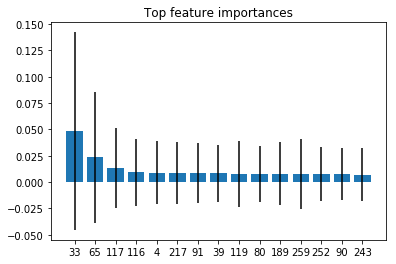

In [19]:
plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), indices)
plt.show()

In [24]:
# A lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
# model = linear_model.Lasso(alpha=0.03, tol=0.01, selection='random', random_state=42)
# model = linear_model.LogisticRegressionCV(cv=5, class_weight='balanced', penalty='l1', Cs=20, solver='liblinear', multi_class='ovr')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, folds=repeated_folds, model_type='sklearn', model=model)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
c = open('./scores_sklearn.csv','w+')
b = open('./prediction_lr_repeated_sklearn.csv','w+')
i = 0
for x in prediction_lr:
    b.write(str(x)+'\n')
    if x<0.1 or x>0.9:
        i+=1
for y in scores:
    c.write(str(y)+'\n')
print(i)
b.close()
c.close()

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(XGBClassifier(n_jobs=-1, random_state=1))

rfe.fit(X_train, y_train)

print('Selected features:')
print(X_train[rfe.support_].tolist())

## ELI5 and permutation importance

ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

In [ ]:
(model.coef_ != 0).sum()

We can see that There are several features with highly positive weights and more features with negative weights. In fact there are only 32 features, which are important according to ELI5. It is worth noticing though, that the model itself had 34 non-zero features, so ELI5 dropped only 2 features.. Let's try using only them for the submission!

In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
c = open('./scores_v1.csv','w+')
b = open('./prediction_lr_repeated_v1.csv','w+')
for x in prediction_lr:
    if x > 0.5:
        b.write('1'+'\n')
    else:
        b.write('0'+'\n')

for y in scores:
    c.write(str(y)+'\n')
value_cou = pd.read_csv('./prediction_lr_repeated_v1.csv')
print(value_cou[value_cou.columns[0]].value_counts())
b.close()
c.close()

Wow, we got improvement from 0.7226 to 0.7486 on CV! But this submission gives 0.845 on leaderboard. So it decreases score slightly. Let's try other things!

### Permutation importance
There is also another way of using eli5 - we could have a look at permutation importance. It works in the following way:
* We fit a model;
* We randomly shuffle one column of validation data and calculate the score;
* If the score dropped significantly, it means that the feature is important;

You can read more about this approach here: https://www.kaggle.com/dansbecker/permutation-importance

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr1, prediction_lr1, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
c = open('./scores_v2.csv','w+')
b = open('./prediction_lr_repeated_v2.csv','w+')
for x in prediction_lr1:
    if x > 0.5:
        b.write('1'+'\n')
    else:
        b.write('0'+'\n')

for y in scores:
    c.write(str(y)+'\n')
value_cou = pd.read_csv('./prediction_lr_repeated_v2.csv')
print(value_cou[value_cou.columns[0]].value_counts())
b.close()
c.close()

Wow, if we select columns by permutation importance, CV score drops significantly. It seems it doesn't work well in out case.

## SHAP

Another interesting tool is SHAP. It also provides explanations for a variety of models.

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
c = open('./scores_v3.csv','w+')
b = open('./prediction_lr_repeated_v3.csv','w+')
for x in prediction_lr:
    if x > 0.5:
        b.write('1'+'\n')
    else:
        b.write('0'+'\n')

for y in scores:
    c.write(str(y)+'\n')
value_cou = pd.read_csv('./prediction_lr_repeated_v3.csv')
print(value_cou[value_cou.columns[0]].value_counts())
b.close()
c.close()

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

It could be difficult to interpret this plot when you see it for the first time. It shows how features impact predictions. For example for feature 33 low values have a negative impact on model predictions (zero is more likely), and high values have a positive impace (ones are more likely). Feature 217 has an opposite effect: low values have a positive impact and high values have a negative impact.

But we will need to select features manually... let's use a library for that!

### Mlextend SequentialFeatureSelector

In [ ]:
sfs1 = SFS(model, 
           k_features=(10, 15), 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           cv=folds,
          n_jobs=-1)

sfs1 = sfs1.fit(X_train, y_train)

In [ ]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
top_features = list(sfs1.k_feature_names_)
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
c = open('./scores_v4.csv','w+')
b = open('./prediction_lr_repeated_v4.csv','w+')
for x in prediction_lr:
    if x > 0.5:
        b.write('1'+'\n')
    else:
        b.write('0'+'\n')

for y in scores:
    c.write(str(y)+'\n')
value_cou = pd.read_csv('./prediction_lr_repeated_v4.csv')
print(value_cou[value_cou.columns[0]].value_counts())
b.close()
c.close()

And this gives 0.811 on leaderboard. Overfitting! It seems that feature selection isn't the best approach. Let's try building various models!

## Modelling

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver': ['newton-cg', 'sag', 'lbfgs']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

So, parameters for logreg are optimal, let's try other models

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
oof_gnb, prediction_gnb, scores_gnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gnb)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
abc = AdaBoostClassifier(**grid_search.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=abc)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
etc = ExtraTreesClassifier(**grid_search.best_params_)
oof_etc, prediction_etc, scores_etc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=etc)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
rfc = RandomForestClassifier(**grid_search.best_params_)
oof_rfc, prediction_rfc, scores_rfc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=rfc)

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
oof_gpc, prediction_gpc, scores_gpc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gpc)

In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
svc = SVC(probability=True, gamma='scale', **grid_search.best_params_)
oof_svc, prediction_svc, scores_svc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=svc)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [2, 3, 5, 10, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }

grid_search = GridSearchCV(knc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knc = KNeighborsClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=knc)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [0.0001, 1, 2, 10]
                 }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=bnb)

In [ ]:
sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
sgd = linear_model.SGDClassifier(eta0=1, tol=0.0001, **grid_search.best_params_)
oof_sgd, prediction_sgd, scores_sgd = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=sgd)

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores})
scores_df['GaussianNB'] = scores_gnb
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['ExtraTreesClassifier'] = scores_etc
scores_df['GaussianProcessClassifier'] = scores_gpc
scores_df['SVC'] = scores_svc
scores_df['KNeighborsClassifier'] = scores_knc
scores_df['BernoulliNB'] = scores_bnb
scores_df['SGDClassifier'] = scores_sgd
scores_df['RandomForestClassifier'] = scores_rfc

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

We can see that logistic regression is superior to most other models. Only SVC is comparable. It seems that other models either overfit or can't work on this small dataset.


Let's try submitting a blend of them!

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
# submission = pd.read_csv('../input/sample_submission.csv')
# submission['target'] = (prediction_lr + prediction_svc) / 2
# submission.to_csv('submission.csv', index=False)

# submission.head()

In [ ]:
plt.hist(prediction_lr, label='logreg');
plt.hist(prediction_svc, label='svc');
plt.hist((prediction_lr + prediction_svc) / 2, label='blend');
plt.title('Distribution of out of fold predictions');
plt.legend();

Sadly blend gives 0.831 on LB. Again no luck.

Let's try generating some features!

### Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

The number of polynomial features is ~45k which is too much. We need some way to select some of them. Let's try use correlations with target.

In [ ]:
cor = pd.DataFrame(X_train_poly).corrwith(y_train)

In [ ]:
sc = []
for i in range(10, 510, 5):
    top_corr_cols = list(cor.abs().sort_values().tail(i).reset_index()['index'].values)
    X_train_poly1 = X_train_poly[:, top_corr_cols]
    X_test_poly1 = X_test_poly[:, top_corr_cols]
    oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)
    sc.append(scores)

In [ ]:
data = [go.Scatter(
        x = list(range(10, 510, 5)),
        y = [np.round(np.mean(i), 4) for i in sc],
        name = 'CV scores'
    )]
layout = go.Layout(dict(title = "Top N poly features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Not suprisingly we overfit.

In [ ]:
top_corr_cols = list(cor.abs().sort_values().tail(300).reset_index()['index'].values)
X_train_poly1 = X_train_poly[:, top_corr_cols]
X_test_poly1 = X_test_poly[:, top_corr_cols]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_poly
# submission.to_csv('submission_poly.csv', index=False)

submission.head()

Score became much lower. So this is also a bad idea

### Adding statistics

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)

Let's compare with repeated KFold.

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1_repeated, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_1_repeated
submission.to_csv('repeated_fold_features.csv', index=False)

submission.head()

CV increased a bit!

### Adding distance features

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
main_cols = X_train.columns.tolist()

In [ ]:
neigh = NearestNeighbors(5, n_jobs=-1)
neigh.fit(X_train)

dists, _ = neigh.kneighbors(X_train, n_neighbors=5)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train['300'] = X_train.std(1)
X_train = np.hstack((X_train, mean_dist.reshape(-1, 1), max_dist.reshape(-1, 1), min_dist.reshape(-1, 1)))

test_dists, _ = neigh.kneighbors(X_test, n_neighbors=5)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test['300'] = X_test.std(1)
X_test = np.hstack((X_test, test_mean_dist.reshape(-1, 1), test_max_dist.reshape(-1, 1), test_min_dist.reshape(-1, 1)))

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_2, prediction_lr_2, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
submission['target'] = prediction_lr_2
submission.to_csv('nn_features.csv', index=False)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = (prediction_lr_1 + prediction_lr_2) / 2
# submission.to_csv('blend.csv', index=False)

submission.head()

## Sklearn feature selection

Sklearn has several methods to do feature selection. Let's try some of them!

In [ ]:
# baseline score
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(5, 100, 5):
    s1 = SelectPercentile(f_classif, percentile=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectPercentile(mutual_info_classif, percentile=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by percentile vs CV",
                  xaxis = dict(title = 'Top N features by percentile'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(10, 301, 10):
    s1 = SelectKBest(f_classif, k=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectKBest(mutual_info_classif, k=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by SelectKBest vs CV",
                  xaxis = dict(title = 'Top N features by SelectKBest'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
selector = SelectKBest(f_classif, k=60)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_1, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_1
# submission.to_csv('top_n_features.csv', index=False)

submission.head()

In [ ]:
scores_list = []
for i in range(10, 301, 5):
    s = RFE(model, i, step=1)
    X_train1 = s.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_list.append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 5)),
        y = scores_list,
        name = 'CV scores RFE'
    )]
layout = go.Layout(dict(title = "Top N features by RFE vs CV",
                  xaxis = dict(title = 'Top N features by RFE'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
selector = RFE(model, 20, step=1)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_rfe_20, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_rfe_20
submission.to_csv('rfe_20.csv', index=False)

submission.head()

### GLM

In [ ]:
selector = SelectKBest(f_classif, k=55)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)

In [ ]:
oof_glm, prediction_glm, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='glm')

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_glm
submission.to_csv('glm.csv', index=False)

submission.head()

### Selected top_features + statistics

In [ ]:
eli5_weights = eli5.formatters.as_dataframe.explain_weights_df(model)
eli5_weights['weight'] = eli5_weights['weight'].abs()
eli5_weights = eli5_weights.sort_values('weight', ascending=False)
eli5_weights

In [ ]:
train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_std'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['simple'],
        name = 'Simple CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_mean'],
        name = 'With mean CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_std'],
        name = 'With std CV scores'
    )]
layout = go.Layout(dict(title = "Top N features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_std'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['simple'],
        name = 'Simple CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_mean'],
        name = 'With mean CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_std'],
        name = 'With std CV scores'
    )]
layout = go.Layout(dict(title = "Top N features vs repeated folds CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:8]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('submission_top8.csv', index=False)

submission.head()

In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:10]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('submission_top10.csv', index=False)

submission.head()